# Разработка стратегии взаимодействия с пользователями для сети фитнес-центров

Сеть фитнес-центров разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных. Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Чтобы бороться с оттоком, отдел по работе с клиентами перевёл в электронный вид множество анкет пользователей. Задача исследования — провести анализ и подготовить план действий по удержанию клиентов.

### Этапы анализа
1. [Открытие файла с данными и изучение общей информации](#one)
2. [Исследовательский анализ данных (EDA)](#two)
3. [Модель прогнозирования оттока пользователей](#three)
4. [Кластеризация пользователей](#four)
5. [Выводы и рекомендации](#five)

## 1. Открытие файла с данными и изучение общей информации <a id="one"></a>

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

from IPython.display import display
import warnings

# Настройка отображения результатов
pd.set_option('precision', 3)
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_columns', 50)
warnings.simplefilter("ignore")
pd.options.display.max_colwidth = 150

In [2]:
# Открытие файла с данными
gym_churn = pd.read_csv('gym_churn.csv')

# Ознакомление с данными
gym_churn.info()
gym_churn.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227,5.000,3,0.020,0.000,0
1,0,1,0,0,1,12,1,31,113.203,12.000,7,1.923,1.910,0
2,0,1,1,0,1,1,0,28,129.448,1.000,2,1.859,1.737,0
3,0,1,1,1,1,12,1,33,62.670,12.000,2,3.206,3.357,0
4,1,1,1,1,1,1,0,26,198.362,1.000,3,1.114,1.120,0


In [3]:
# Приведение наименований колонок к ниждему регистру
gym_churn.columns = map(str.lower, gym_churn.columns)

In [4]:
# Проверка на наличие дубликатов
gym_churn.duplicated().sum()

0

In [5]:
gym_churn.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227,5.000,3,0.020,0.000,0
1,0,1,0,0,1,12,1,31,113.203,12.000,7,1.923,1.910,0
2,0,1,1,0,1,1,0,28,129.448,1.000,2,1.859,1.737,0
3,0,1,1,1,1,12,1,33,62.670,12.000,2,3.206,3.357,0
4,1,1,1,1,1,1,0,26,198.362,1.000,3,1.114,1.120,0


Фитнес-клуб предоставил сведения в csv-файле. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Для удобства наименования колонок приведены к нижнему регистру. Набор данных включает следующие поля:
    
* churn — факт оттока в текущем месяце;

Данные пользователя за предыдущий до проверки факта оттока месяц:
* gender — пол
* near_location — проживание или работа в районе, где находится фитнес-центр
* partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
* promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
* phone — наличие контактного телефона
* age — возраст
* lifetime — время с момента первого обращения в фитнес-центр (в месяцах)
    
Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
* contract_period — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
* month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах)
* group_visits — факт посещения групповых занятий
* avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента
* avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц
* avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон
    
Всего предоставлена информация о **4 тыс. клиентах** клуба. В данных **отсутствуют пропуски и дубликаты**. Все признаки, как качественные, так и количественные, имеют числовой формат.

## 2. Исследовательский анализ данных (EDA) <a id="two"></a>

In [6]:
# Описательная статистика
gym_churn.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000
mean,0.510,0.845,0.487,0.308,0.903,4.681,0.412,29.184,146.944,4.323,3.725,1.879,1.767,0.265
std,0.500,0.362,0.500,0.462,0.295,4.550,0.492,3.258,96.356,4.191,3.749,0.972,1.053,0.442
min,0.000,0.000,0.000,0.000,0.000,1.000,0.000,18.000,0.148,1.000,0.000,0.000,0.000,0.000
25%,0.000,1.000,0.000,0.000,1.000,1.000,0.000,27.000,68.869,1.000,1.000,1.181,0.963,0.000
50%,1.000,1.000,0.000,0.000,1.000,1.000,0.000,29.000,136.220,1.000,3.000,1.833,1.720,0.000
75%,1.000,1.000,1.000,1.000,1.000,6.000,1.000,31.000,210.950,6.000,5.000,2.536,2.510,1.000
max,1.000,1.000,1.000,1.000,1.000,12.000,1.000,41.000,552.591,12.000,31.000,6.024,6.147,1.000


In [7]:
# Описательная статистика зависимой переменной "churn"
gym_churn['churn'].describe()

count   4000.000
mean       0.265
std        0.442
min        0.000
25%        0.000
50%        0.000
75%        1.000
max        1.000
Name: churn, dtype: float64


_______________________________ gender _______________________________
count   4000.000
mean       0.510
std        0.500
min        0.000
25%        0.000
50%        1.000
75%        1.000
max        1.000
Name: gender, dtype: float64


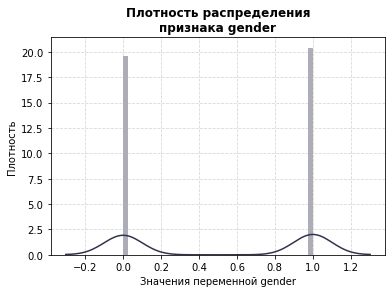


_______________________________ near_location _______________________________
count   4000.000
mean       0.845
std        0.362
min        0.000
25%        1.000
50%        1.000
75%        1.000
max        1.000
Name: near_location, dtype: float64


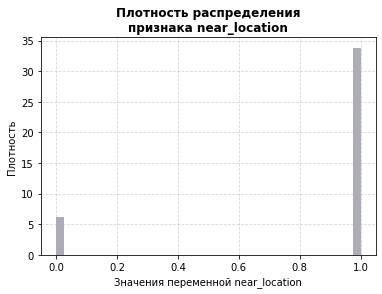


_______________________________ partner _______________________________
count   4000.000
mean       0.487
std        0.500
min        0.000
25%        0.000
50%        0.000
75%        1.000
max        1.000
Name: partner, dtype: float64


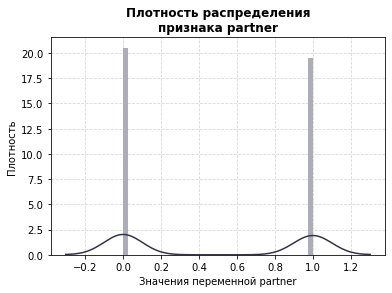


_______________________________ promo_friends _______________________________
count   4000.000
mean       0.308
std        0.462
min        0.000
25%        0.000
50%        0.000
75%        1.000
max        1.000
Name: promo_friends, dtype: float64


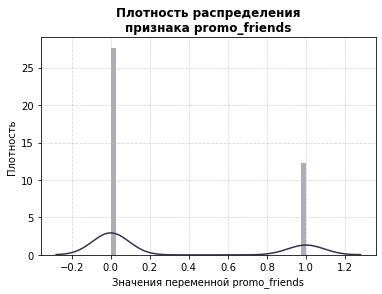


_______________________________ phone _______________________________
count   4000.000
mean       0.903
std        0.295
min        0.000
25%        1.000
50%        1.000
75%        1.000
max        1.000
Name: phone, dtype: float64


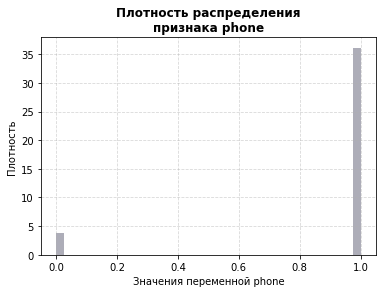


_______________________________ contract_period _______________________________
count   4000.000
mean       4.681
std        4.550
min        1.000
25%        1.000
50%        1.000
75%        6.000
max       12.000
Name: contract_period, dtype: float64


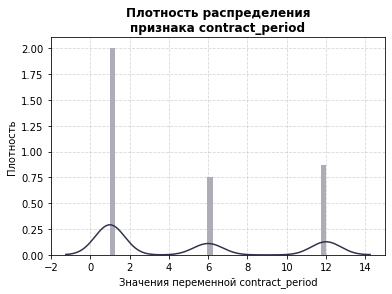


_______________________________ group_visits _______________________________
count   4000.000
mean       0.412
std        0.492
min        0.000
25%        0.000
50%        0.000
75%        1.000
max        1.000
Name: group_visits, dtype: float64


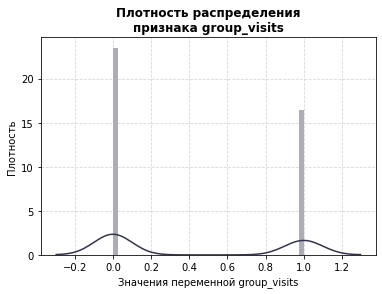


_______________________________ age _______________________________
count   4000.000
mean      29.184
std        3.258
min       18.000
25%       27.000
50%       29.000
75%       31.000
max       41.000
Name: age, dtype: float64


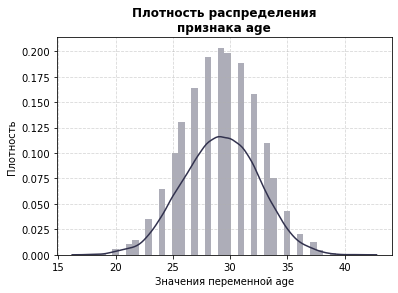


_______________________________ avg_additional_charges_total _______________________________
count   4000.000
mean     146.944
std       96.356
min        0.148
25%       68.869
50%      136.220
75%      210.950
max      552.591
Name: avg_additional_charges_total, dtype: float64


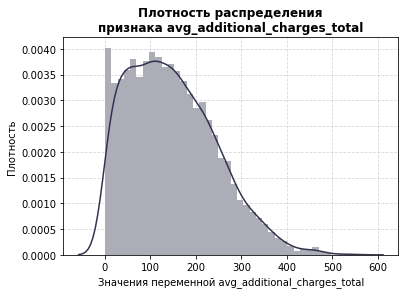


_______________________________ month_to_end_contract _______________________________
count   4000.000
mean       4.323
std        4.191
min        1.000
25%        1.000
50%        1.000
75%        6.000
max       12.000
Name: month_to_end_contract, dtype: float64


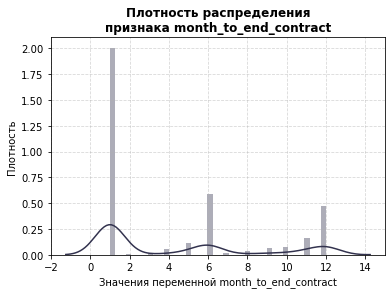


_______________________________ lifetime _______________________________
count   4000.000
mean       3.725
std        3.749
min        0.000
25%        1.000
50%        3.000
75%        5.000
max       31.000
Name: lifetime, dtype: float64


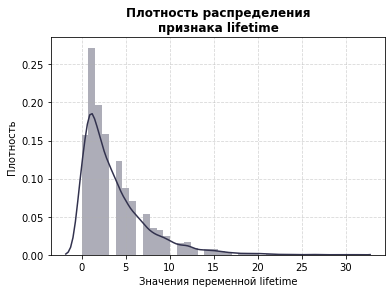


_______________________________ avg_class_frequency_total _______________________________
count   4000.000
mean       1.879
std        0.972
min        0.000
25%        1.181
50%        1.833
75%        2.536
max        6.024
Name: avg_class_frequency_total, dtype: float64


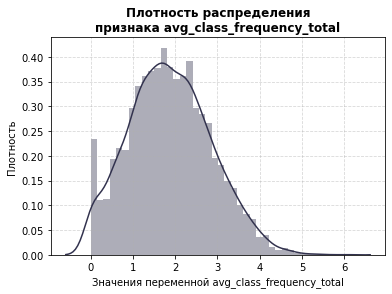


_______________________________ avg_class_frequency_current_month _______________________________
count   4000.000
mean       1.767
std        1.053
min        0.000
25%        0.963
50%        1.720
75%        2.510
max        6.147
Name: avg_class_frequency_current_month, dtype: float64


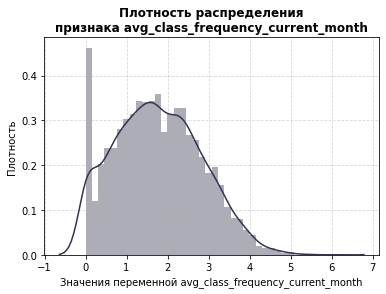

In [8]:
# Описательная статистика признаков
for col in gym_churn.drop('churn', axis = 1).columns:
    print()
    print('_______________________________',col,'_______________________________')
    print(gym_churn[col].describe())
    sns.distplot(gym_churn[col], bins=40, color='#32324e')
    plt.title(f"Плотность распределения\nпризнака {col}", fontweight='bold')
    plt.xlabel(f"Значения переменной {col}")
    plt.ylabel("Плотность")
    plt.grid(linestyle='--', alpha=.5)
    plt.show()

In [9]:
# Анализ значений признаков в двух группах: 1) тех, кто остался; 2) тех, кто ушел в отток;
gym_churn.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510,0.873,0.534,0.354,0.904,5.747,0.464,29.977,158.446,5.283,4.712,2.025,2.028
1,0.511,0.768,0.355,0.184,0.903,1.729,0.269,26.990,115.083,1.663,0.991,1.475,1.045



_______________________________ gender _______________________________


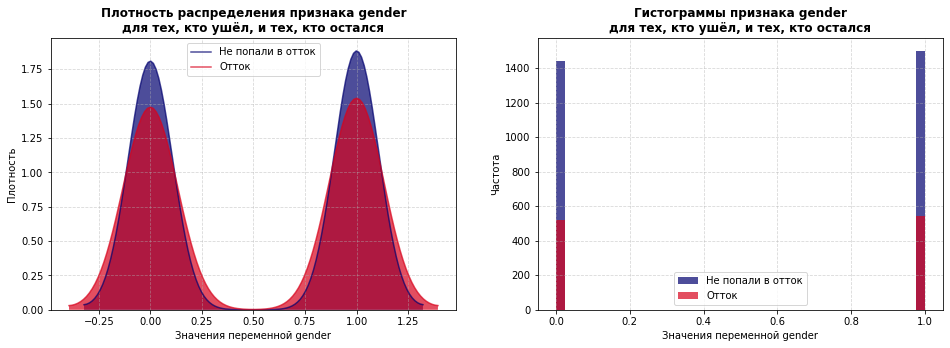


_______________________________ near_location _______________________________


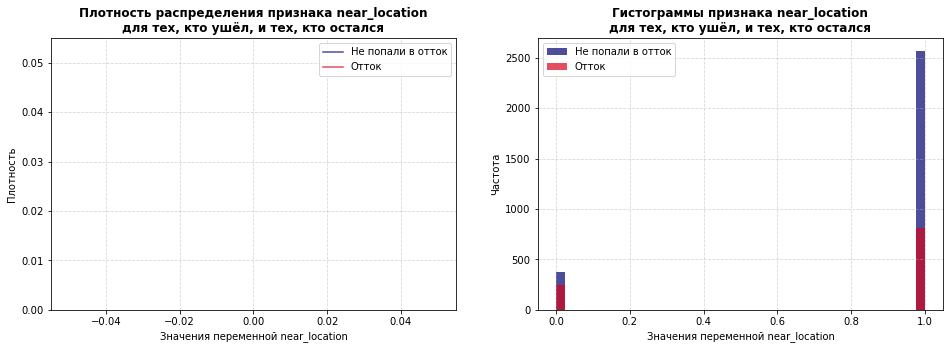


_______________________________ partner _______________________________


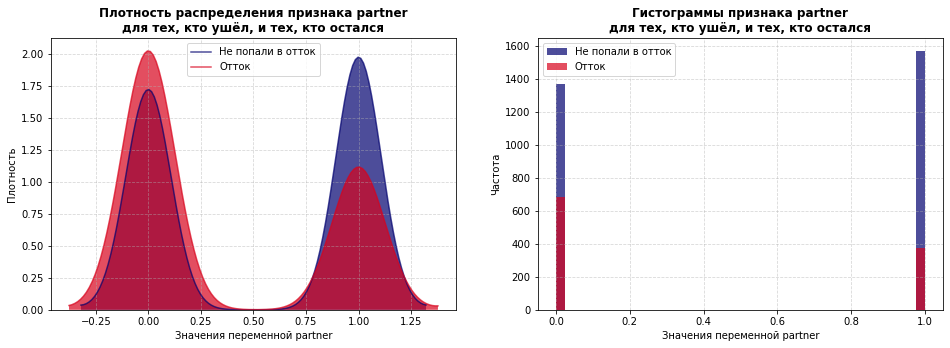


_______________________________ promo_friends _______________________________


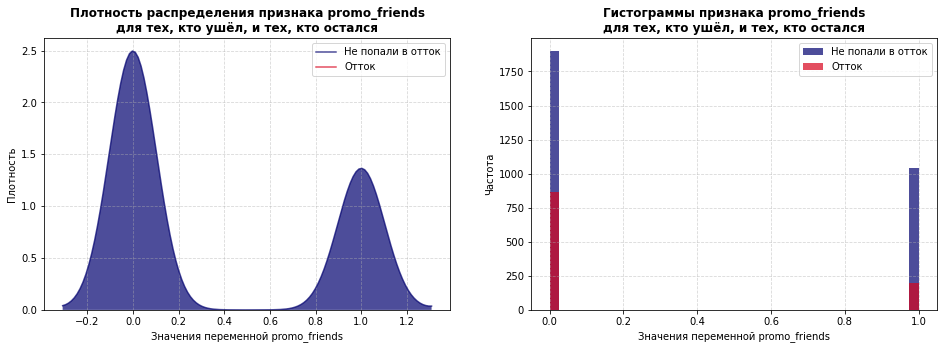


_______________________________ phone _______________________________


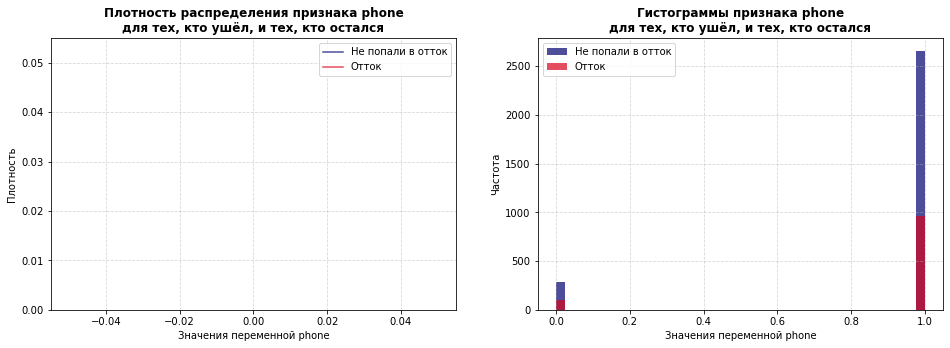


_______________________________ contract_period _______________________________


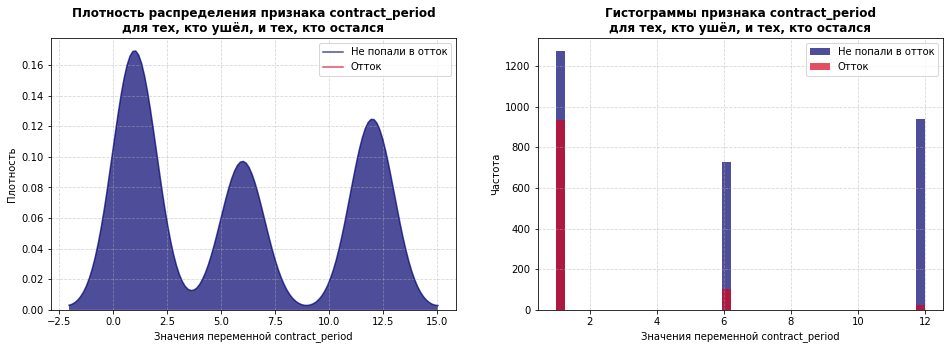


_______________________________ group_visits _______________________________


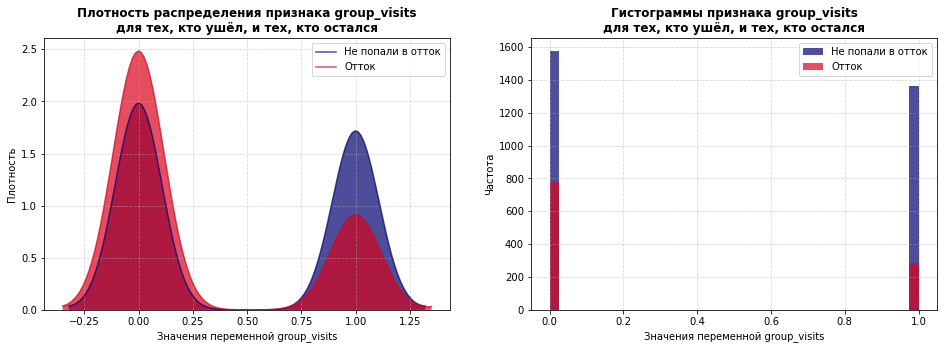


_______________________________ age _______________________________


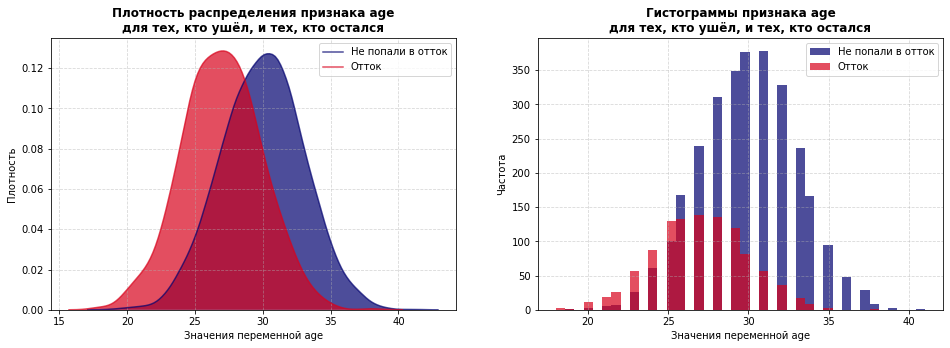


_______________________________ avg_additional_charges_total _______________________________


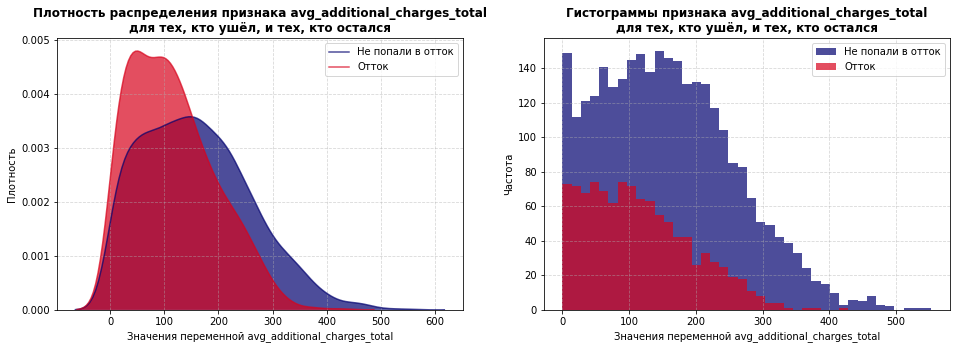


_______________________________ month_to_end_contract _______________________________


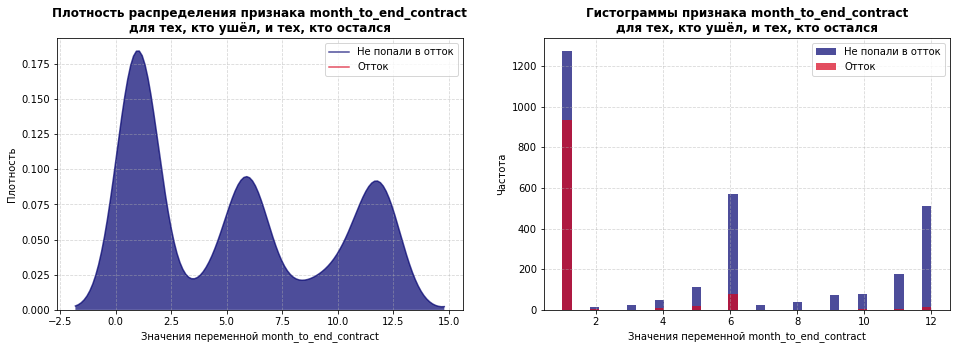


_______________________________ lifetime _______________________________


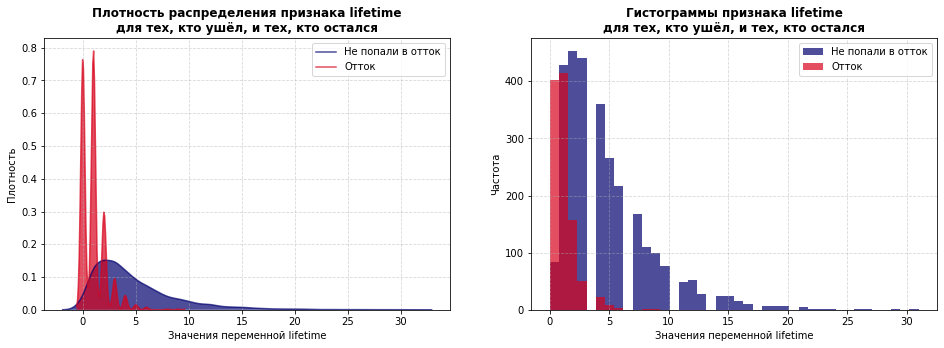


_______________________________ avg_class_frequency_total _______________________________


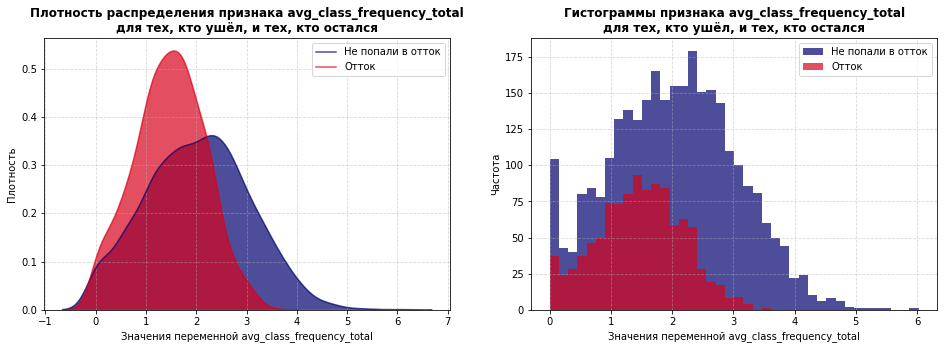


_______________________________ avg_class_frequency_current_month _______________________________


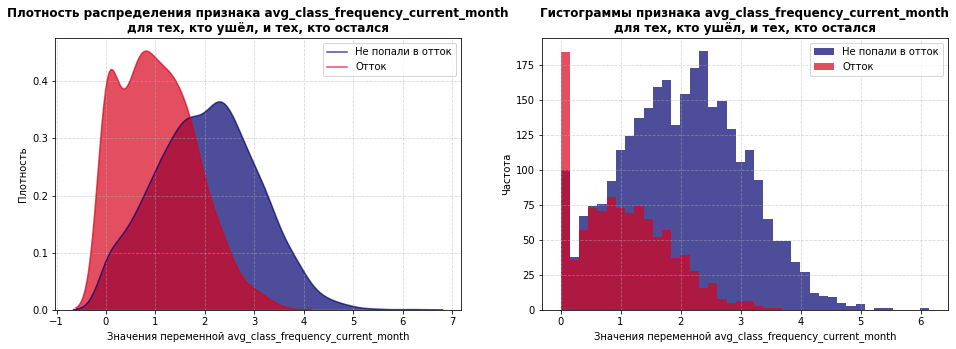

In [10]:
for col in gym_churn.drop('churn', axis = 1).columns:
    print()
    print('_______________________________',col,'_______________________________')
    fig, axs = plt.subplots(1, 2, figsize=(16,5)) 
    sns.kdeplot(gym_churn[gym_churn['churn'] == 0][col], 
                shade=True, 
                color="#01016f", 
                label='Не попали в отток',
                ax=axs[0],
                alpha=0.7)
    sns.kdeplot(gym_churn[gym_churn['churn'] == 1][col], 
                shade=True, 
                color='#d8031c',
                label='Отток',
                ax=axs[0],
                alpha=0.7)
    axs[0].set_title(f"Плотность распределения признака {col}\nдля тех, кто ушёл, и тех, кто остался", fontweight='bold')
    axs[0].set_xlabel(f"Значения переменной {col}")
    axs[0].set_ylabel("Плотность")
    axs[0].grid(linestyle='--', alpha=0.5)

    a1 = gym_churn[col].min()
    a2 = gym_churn[col].max()
    gym_churn[gym_churn['churn'] == 0].plot(kind='hist', 
                                            y=col, 
                                            range=(a1, a2), 
                                            bins=40, 
                                            alpha=0.7, 
                                            color='#01016f',
                                            label='Не попали в отток', 
                                            ax=axs[1])
    gym_churn[gym_churn['churn'] == 1].plot(kind='hist', 
                                            y=col, 
                                            range=(a1, a2), 
                                            bins=40, 
                                            alpha=0.7, 
                                            color='#d8031c',
                                            label='Отток', 
                                            ax=axs[1], 
                                            legend=True)
    axs[1].grid(linestyle='--', alpha=0.5)
    axs[1].set_title(f"Гистограммы признака {col}\nдля тех, кто ушёл, и тех, кто остался", fontweight='bold')
    axs[1].set_xlabel(f"Значения переменной {col}")
    axs[1].set_ylabel("Частота")
    plt.show()

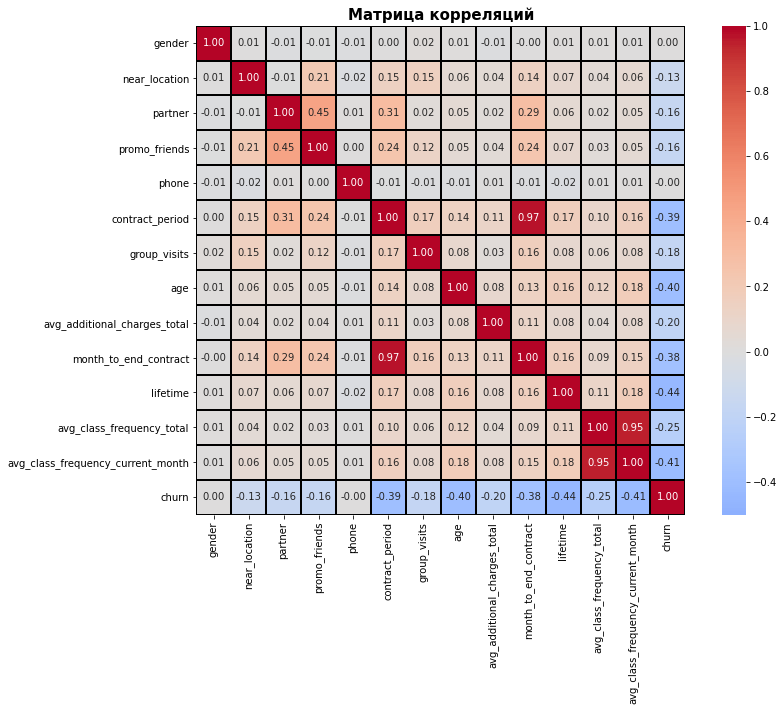

In [11]:
# Матрица корреляций
cm = gym_churn.corr()

plt.figure(figsize=(13, 9))
plt.title('Матрица корреляций', fontweight='bold', fontsize=15)
sns.heatmap(cm, 
            annot=True, 
            square=True, 
            cmap='coolwarm', 
            fmt=".2f", 
            center=0, 
            vmin=-0.5, 
            vmax=1,
            linewidths=1, 
            linecolor='black')
plt.show()

**Портрет среднестатистического клиента клуба**
    
Среднестатистическому клиенту фитнес-клуба 29 лет. Он (или она) живет или работает рядом с клубом и имеет абонемент на 1 месяц. Он/она ходит в зал примерно 2 раза в неделю и тратит около 140 руб. на дополнительные услуги. Стоит отметить, что такой клиент не участвует в бонусных программах (скидки для партнеров клуба и акция «приведи друга»), а также не посещает групповые занятия, однако пользуется услугами клуба уже более 3 месяцев.
    
**Портрет клиента, склонного к оттоку**
    
К оттоку более склонны клиенты, имеющие краткосрочный абонемент и только первый месяц пользующиеся услугами клуба. Такие клиенты посещают зал в среднем раз в неделю.  
    
**EDA. Анализ качества признаков и формулировка гипотез**
    
*Целевая переменная*: целевая переменная "churn" является бинарной, т.е. принимает значение 1 при попадании клиента в отток (≈27% выборки) и 0 - если клиент в отток не попал (≈73% клиентов) (классы не сбалансированы).
    
*Признаки*: признаки, характеризующие клиентов, представлены как категориальными, так и количественными переменными. Существенных выбросов и аномальных значений при анализе распределений данных переменных не выявлено.    

За исключением переменных "gender" и "phone", средние значения признаков и их распределения для групп пользователей, попавших и не попавших в отток, отличаются, что позволяет предположить наличие их влияния на факт оттока.
    
В то же время значения признаков "month_to_end_contract" (срок до окончания текущего действующего абонемента) и "contract_period" (длительность текущего действующего абонемента), а также "avg_class_frequency_total" (средняя частота посещений в неделю за все время с начала действия абонемента) и "avg_class_frequency_current_month" (средняя частота посещений в неделю за предыдущий месяц) сильно коррелируют между собой. Чтобы избежать мультиколлинеарности исключим признаки "month_to_end_contract" и "avg_class_frequency_total" из модели.

## 3. Модель прогнозирования оттока пользователей <a id="three"></a>

In [12]:
# Разделение данных на признаки (матрица X) и целевую переменную (y)
X = gym_churn.drop(['churn', 'month_to_end_contract', 'avg_class_frequency_total'], axis = 1)
y = gym_churn['churn']

# Разделение на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [13]:
# Стандартизация данных
sc = StandardScaler()
X_train_st = sc.fit_transform(X_train)
X_test_st = sc.transform(X_test)

In [14]:
# Cписок моделей
models = [LogisticRegression(random_state=0), 
          DecisionTreeClassifier(random_state=0), 
          RandomForestClassifier(random_state=0), 
          GradientBoostingClassifier(random_state=0)]

In [15]:
# Написание функции, которая принимает на вход модель и данные и выводит метрики
def predictions(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
    print('F1: {:.2f}'.format(f1_score(y_test, y_pred)))
    print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, y_prob)))

In [16]:
# Расчет метрик для моделей из списка
for i in models:
    print('___________________________________________________________________________________')
    print(i)
    predictions(i, X_train_st, y_train, X_test_st, y_test)

___________________________________________________________________________________
LogisticRegression(random_state=0)
Accuracy: 0.92
Precision: 0.85
Recall: 0.84
F1: 0.84
ROC_AUC: 0.97
___________________________________________________________________________________
DecisionTreeClassifier(random_state=0)
Accuracy: 0.87
Precision: 0.74
Recall: 0.78
F1: 0.76
ROC_AUC: 0.84
___________________________________________________________________________________
RandomForestClassifier(random_state=0)
Accuracy: 0.91
Precision: 0.85
Recall: 0.77
F1: 0.81
ROC_AUC: 0.96
___________________________________________________________________________________
GradientBoostingClassifier(random_state=0)
Accuracy: 0.91
Precision: 0.86
Recall: 0.81
F1: 0.83
ROC_AUC: 0.97


### *Судя по рассматриваемым метрикам, наилучшие результаты дает самый простой из анализируемых алгоритмов - логистическая регрессия.*

In [17]:
# Обучение финальной модели
final_model = LogisticRegression(random_state=0)
final_model.fit(X_train_st, y_train)
y_pred_fin = final_model.predict(X_test_st)
[coef] = final_model.coef_
importance = abs(coef)

In [18]:
# Датафрейм с именами признаков и их важностью
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': importance})
display(feature_importance.sort_values('importance', ascending = False))

,feature,importance
9,lifetime,3.650
5,contract_period,1.406
10,avg_class_frequency_current_month,1.294
7,age,1.173
8,avg_additional_charges_total,0.571
6,group_visits,0.383
3,promo_friends,0.154
4,phone,0.077
1,near_location,0.064
2,partner,0.057


Для решения **задачи бинарной классификации (обучение с учителем)** подходят следующие алгоритмы: логистическая регрессия, дерево принятия решений, случайный лес и градиентный бустинг. Выбор наилучшей модели (оценка качества получаемых прогнозов) проведен на основе следующих метрик:  
* accuracy (доля правильных ответов)
* precision (точность, т.е. доля правильных ответов только среди целевого класса)
* recall (полнота, т.е.  сколько реальных объектов целевого класса обнаружено с помощью модели)
* F1-score (метрика, отражающая баланс между precision и recall)
* AUC-ROC (площади под кривой ошибок)
    
Стоит отметить, что, так как выборка не сбалансирована по классам, метрика accuracy не слишком показательна.
    
Так, **наилучшие результаты из рассмотренных алгоритмов показывает модель логистической регрессии**, которая интерпретируется проще других.
    
В соответствии с данной моделью наиболее важными признаками при определении того, попадет ли клиент в отток, являются следующие: время с момента первого обращения в фитнес-центр, длительность текущего действующего абонемента, средняя частота посещений в неделю за предыдущий месяц и возраст клиента.

## 4. Кластеризация пользователей <a id="four"></a>

In [19]:
# Стандартизация данных для кластеризации
X_cluster = gym_churn.drop('churn', axis = 1)
sc_cluster = StandardScaler()
X_cluster_sc = sc_cluster.fit_transform(X_cluster)

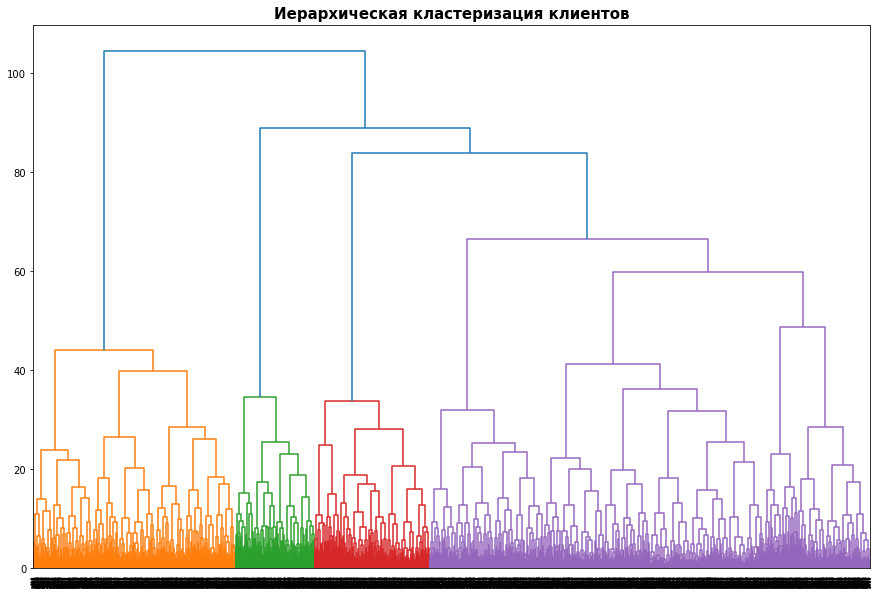

In [20]:
# Расчет матрицы расстояний между всеми объектами (клиентами)
linked = linkage(X_cluster_sc, method = 'ward')

# Отрисовка дендрограммы
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация клиентов', fontweight='bold', fontsize=15)
plt.show()

In [21]:
# Модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. 
km = KMeans(n_clusters = 5, random_state=0) # число кластеров равно 5

# Прогнозирование кластеров
labels = km.fit_predict(X_cluster_sc)

In [22]:
# Добавление метки кластера в датасет
gym_churn['cluster'] = labels + 1
display(gym_churn.head())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster
0,1,1,1,1,0,6,1,29,14.227,5.000,3,0.020,0.000,0,1
1,0,1,0,0,1,12,1,31,113.203,12.000,7,1.923,1.910,0,5
2,0,1,1,0,1,1,0,28,129.448,1.000,2,1.859,1.737,0,4
3,0,1,1,1,1,12,1,33,62.670,12.000,2,3.206,3.357,0,5
4,1,1,1,1,1,1,0,26,198.362,1.000,3,1.114,1.120,0,4


In [23]:
# Cредние значения признаков для кластеров
gym_churn.groupby('cluster').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
1,0.522,0.862,0.470,0.306,0.000,4.787,0.426,29.301,143.958,4.475,3.925,1.847,1.716,0.268
2,0.481,0.813,0.000,0.086,1.000,1.867,0.325,28.145,131.369,1.791,2.346,1.326,1.087,0.550
3,0.560,0.858,0.338,0.197,0.999,2.730,0.449,30.196,164.579,2.520,5.011,2.928,2.934,0.048
4,0.510,0.750,1.000,0.452,1.000,2.554,0.303,28.499,129.813,2.370,2.832,1.355,1.176,0.396
5,0.496,0.943,0.752,0.542,1.000,11.353,0.564,29.994,164.564,10.376,4.817,2.028,2.020,0.024


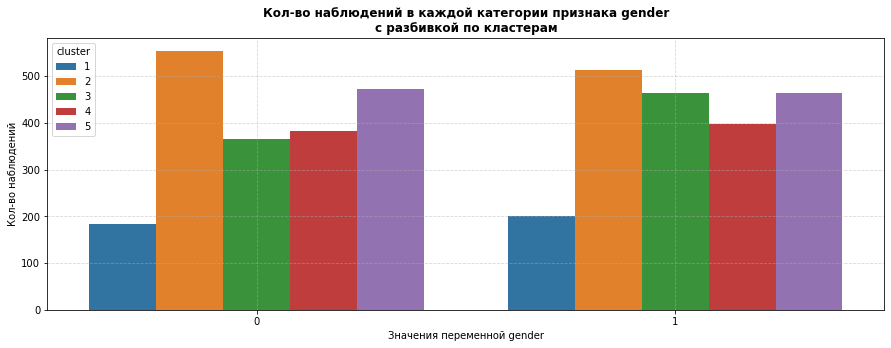

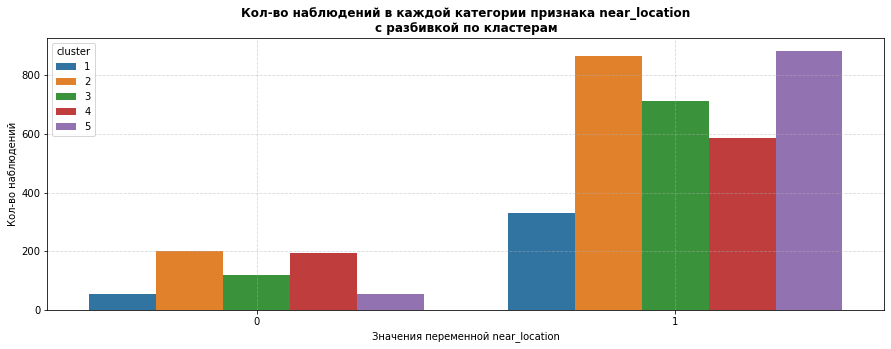

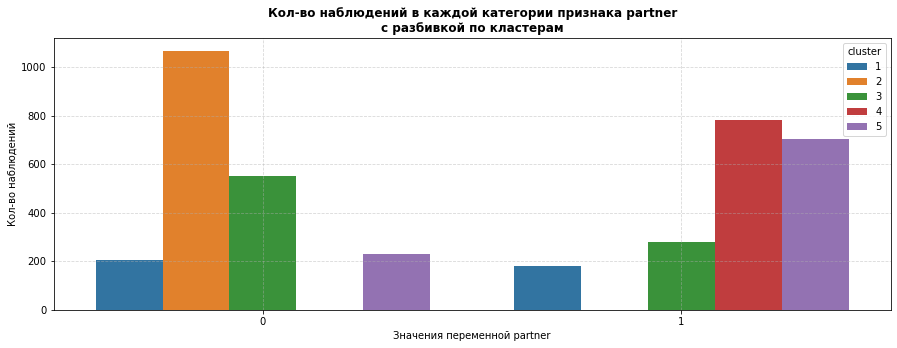

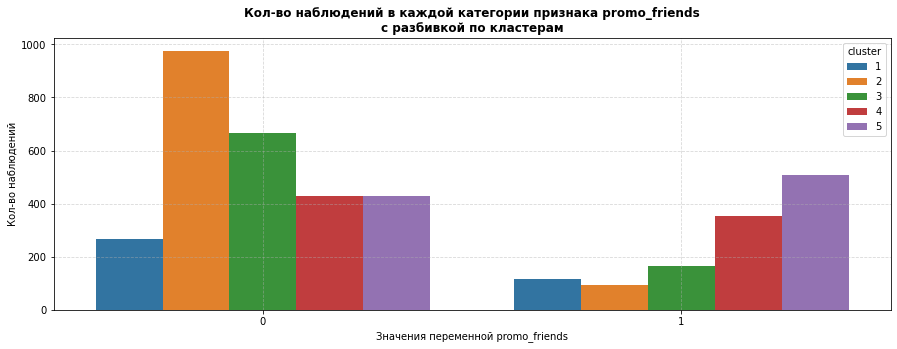

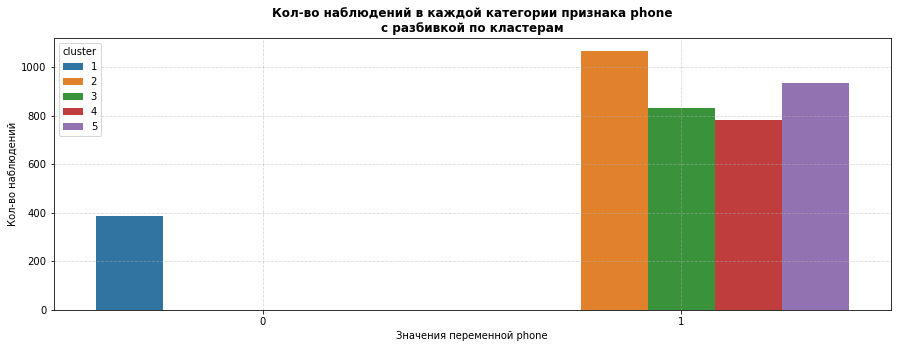

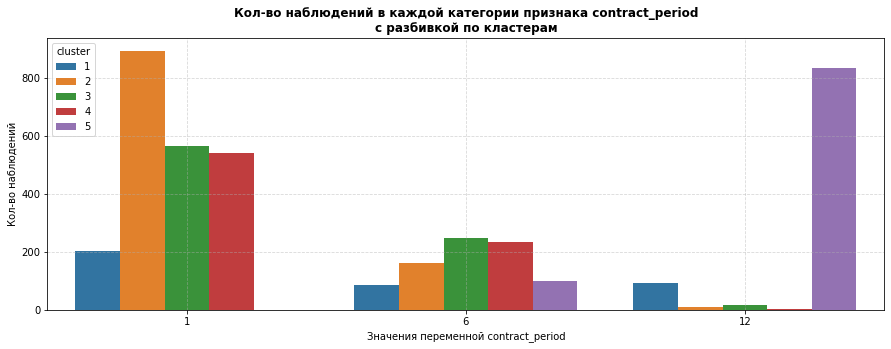

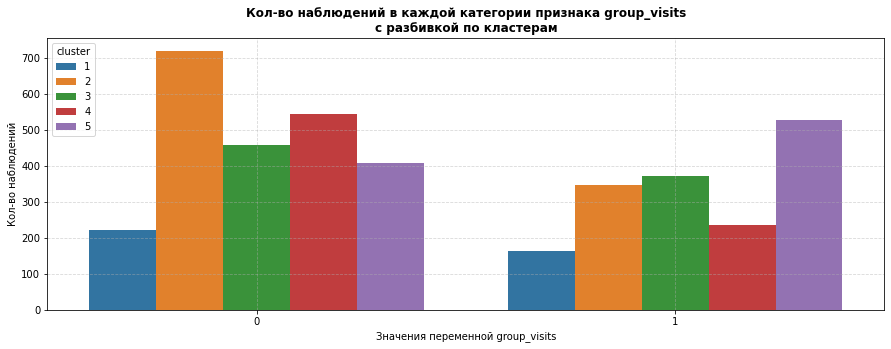

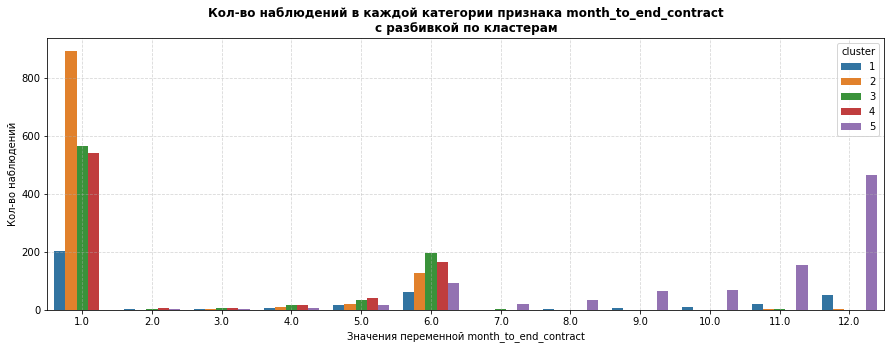

In [24]:
# Визуализация разпределения признаков для кластеров
# Категориальные переменные
for col in ['gender', 
            'near_location', 
            'partner', 
            'promo_friends', 
            'phone', 
            'contract_period', 
            'group_visits', 
            'month_to_end_contract']:
    
    plt.figure(figsize=(15, 5))
    sns.countplot(x=col, hue="cluster", data=gym_churn)
    plt.title(f"Кол-во наблюдений в каждой категории признака {col}\nc разбивкой по кластерам", fontweight='bold')
    plt.xlabel(f"Значения переменной {col}")
    plt.ylabel("Кол-во наблюдений")
    plt.grid(linestyle='--', alpha=.5)
    plt.show() 

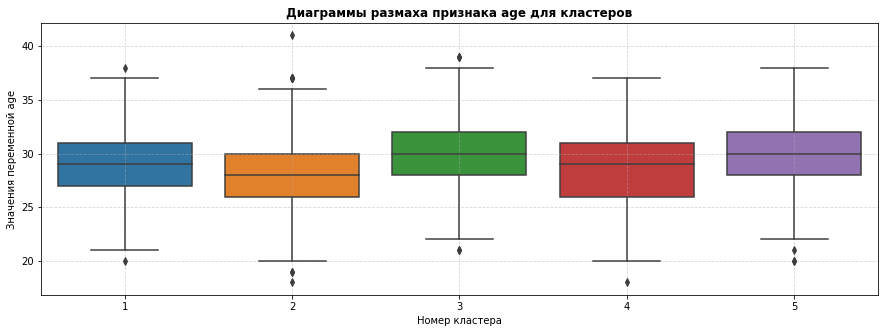

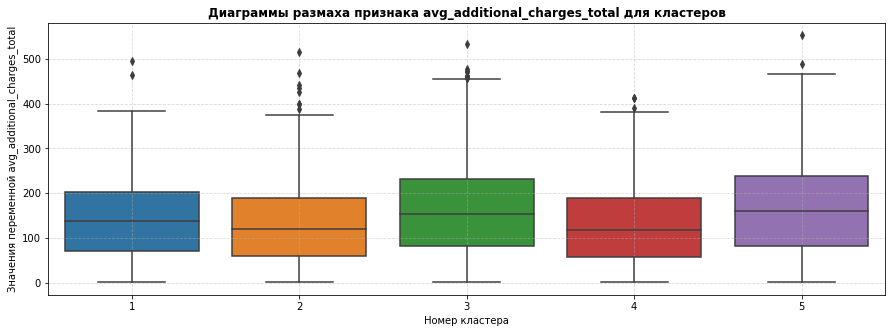

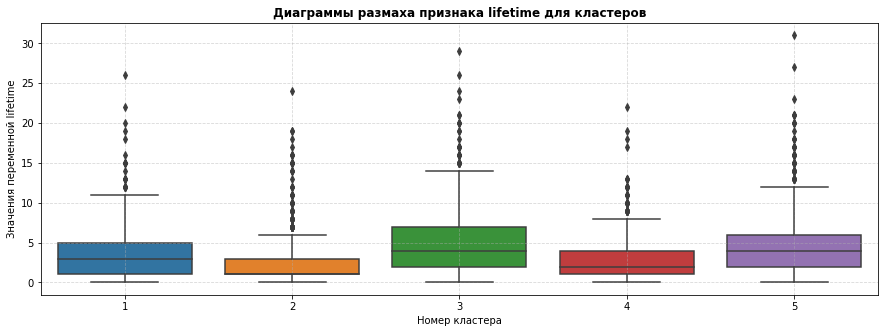

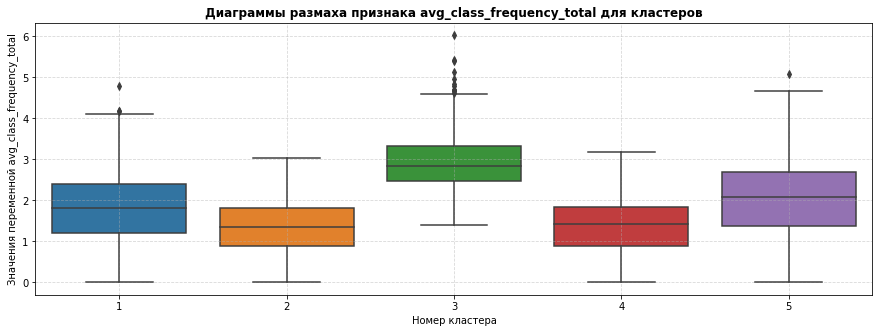

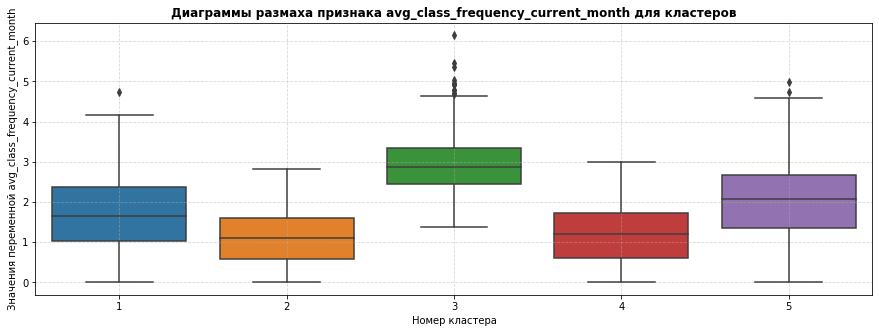

In [25]:
# Количественные переменные
for col in ['age', 
            'avg_additional_charges_total', 
            'lifetime', 
            'avg_class_frequency_total', 
            'avg_class_frequency_current_month']:
    
    plt.figure(figsize=(15, 5))
    sns.boxplot(x="cluster", y=col, data=gym_churn)
    plt.title(f"Диаграммы размаха признака {col} для кластеров", fontweight='bold')
    plt.xlabel("Номер кластера")
    plt.ylabel(f"Значения переменной {col}")
    plt.grid(linestyle='--', alpha=.5)
    plt.show()    

In [26]:
# Доля оттока по кластерам
display(gym_churn.groupby('cluster')['churn'].mean().reset_index())

,cluster,churn
0,1,0.268
1,2,0.550
2,3,0.048
3,4,0.396
4,5,0.024


Для сегментации клиентов использованы **алгоритмы кластеризации (обучение без учителя)**. 
    
Результаты вычисления матрицы расстояний между всеми объектами (клиентами в выборке) и иерархической кластеризация свидетельствуют о том, что целесообразно выделить **4-6 кластеров (по условию, выделим 5)**. Для прогнозирования кластеров клиентов в выборке использован алгоритм K-Means. 
    
**Основные характеристики полученных кластеров**

* По половому признаку клиенты по кластерам распределены равномерно, т.е. нельзя сказать, что в каком-то кластере представлено больше представителей того или иного пола.
* Почти все клиенты, проживающие и работающие далеко от фитнес-центра, попали в один (третий) кластер.
* Средний срок, который клиент уже является членом клуба (с момента первого обращения), короче всего для 3 и 4 кластеров. Для данных кластеров также более характерно наличие краткосрочного абонемента (на месяц) и не участие в акции "приведи друга".
* Большинство клиентов, купивших годовой абонемент, попали в первый кластер.
* Клиенты, попавшие в пятый кластер, характеризуются наибольшей активностью (чаще всего посещают занятия).
* Так, более всего к оттоку склонны клиенты 3 и 4 кластеров, а к более надежным относятся клиенты, попавшие в 1 и 5 кластеры.

## 5. Выводы и рекомендации <a id="five"></a>

**Портрет среднестатистического клиента клуба**
    
Среднестатистическому клиенту фитнес-клуба 29 лет. Он (или она) живет или работает рядом с клубом и имеет абонемент на 1 месяц. Он/она ходит в зал примерно 2 раза в неделю и тратит около 140 руб. на дополнительные услуги. Стоит отметить, что такой клиент не участвует в бонусных программах (скидки для партнеров клуба и акция «приведи друга»), а также не посещает групповые занятия, однако пользуется услугами клуба уже более 3 месяцев.
    
**Портрет клиента, склонного к оттоку**
    
К оттоку более склонны клиенты, имеющие краткосрочный абонемент и только первый месяц пользующиеся услугами клуба. Такие клиенты посещают зал в среднем раз в неделю.  
    
**Прогнозирование вероятности оттока** 
  
Целевая переменная "churn" является бинарной, т.е. принимает значение 1 при попадании клиента в отток и 0 - если клиент в отток не попал. Для решения задачи бинарной классификации (обучение с учителем) подходят следующие алгоритмы: логистическая регрессия, дерево принятия решений, случайный лес и градиентный бустинг. Наилучшие результаты из рассмотренных алгоритмов показывает модель логистической регрессии.

В соответствии с данной моделью наиболее важными признаками при определении того, попадет ли клиент в отток, являются следующие: время с момента первого обращения в фитнес-центр, длительность текущего действующего абонемента, средняя частота посещений в неделю за предыдущий месяц и возраст клиента.
    
**Сегментация клиентов**   
    
Для сегментации клиентов использованы алгоритмы кластеризации (обучение без учителя). Результаты вычисления матрицы расстояний между всеми объектами (клиентами в выборке) и иерархической кластеризация свидетельствуют о том, что целесообразно выделить 4-6 кластеров (по условию, выделим 5). 
    
Более всего к оттоку склонны клиенты 3 и 4 кластеров, в которые попали клиенты, проживающие и работающие далеко от клуба, и не так давно обратившиеся в фитнес-клуб впервые. Для данных кластеров также более характерно наличие краткосрочного абонемента (на месяц) и не участие в акции "приведи друга".

К более надежным относятся клиенты, попавшие в 1 (большинство клиентов с годовыми абонементами) и в 5 кластеры (самые активные пользователи клуба).


***Таким образом, целесообразно ввести или усилить меры, направленные на продление времени "взаимодействия" клиента с клубом, к примеру, ввести бонусы и дополнительные скидки на услуги при покупке повторного абонемента, рассмотреть возможность установления прогрессивной шкалы скидок, предложить продление абонемента на более выгодных условиях.
Для расширения клиентской базы разумнее всего сконцентрировать усилия на привлечении клиентов, проживающих и работающих рядом с клубами.***    